Token-wise cosine similarity: tensor([[ 0.0657, -0.0510,  0.0656,  0.0162, -0.0030,  0.1291,  0.0061,  0.0101,
          0.0919,  0.0547,  0.0415,  0.0485,  0.0829,  0.0423,  0.0195, -0.0207,
         -0.0321, -0.0052,  0.0189,  0.0999, -0.0243, -0.0020, -0.0182,  0.0635,
         -0.0261,  0.0807,  0.0559,  0.0035,  0.0607, -0.0928, -0.0755, -0.0049,
          0.0643,  0.0771, -0.1010,  0.0382,  0.0164, -0.0057,  0.0294,  0.0908,
          0.0282, -0.0460, -0.0358, -0.0407, -0.0404, -0.0518,  0.1124,  0.0629,
         -0.0642, -0.0830,  0.1055,  0.0641,  0.0033,  0.0875,  0.0735,  0.0362,
          0.0499, -0.0216, -0.0622, -0.1035,  0.0498,  0.0929,  0.0519, -0.0009,
          0.0256,  0.0609,  0.0262,  0.0232, -0.0256, -0.0173,  0.0678, -0.0409,
         -0.0415, -0.0515, -0.0156,  0.0343,  0.0309,  0.0560,  0.0871,  0.0832,
          0.0792,  0.0334,  0.0669,  0.0298,  0.0202, -0.0491, -0.0437, -0.0619,
         -0.0338, -0.0026,  0.0524,  0.0292,  0.0048,  0.0601,  0.0007, -0.0693

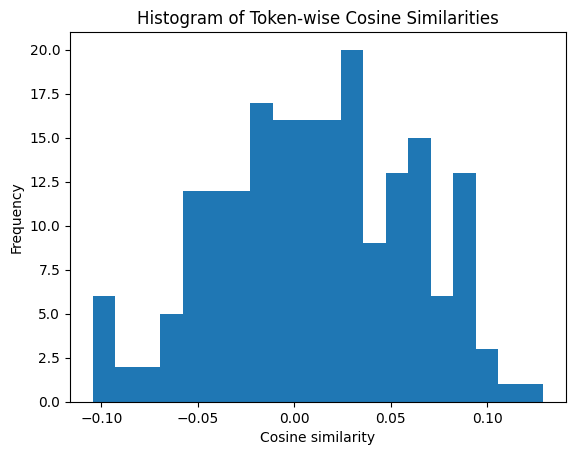

In [4]:
import torch
import torch.nn as nn
import timm

class ViTEncoder(nn.Module):
    def __init__(self):
        super(ViTEncoder, self).__init__()
        # Create a ViT small model with the classifier head removed.
        self.model = timm.create_model(
            'vit_small_patch16_224.augreg_in21k_ft_in1k',
            pretrained=True,
            num_classes=0  # removes the classifier layer
        )
        # Note: The model expects images to be preprocessed as in its data config.

    def forward(self, x):
        # Forward pass through the ViT model to extract token embeddings.
        # The output shape is typically (B, num_tokens, embed_dim)
        latent = self.model.forward_features(x)
        return latent

class ViTDecoder(nn.Module):
    def __init__(self, embed_dim=384):
        super(ViTDecoder, self).__init__()
        # A simple decoder that operates on each token embedding independently.
        # This decoder "reconstructs" the embedding space of each token.
        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )
        
    def forward(self, z):
        # z shape: (B, num_tokens, embed_dim)
        # Apply the MLP to each token (the linear layers work on the last dimension).
        reconstructed = self.decoder(z)
        return reconstructed

class VitAutoencoder(nn.Module):
    def __init__(self):
        super(VitAutoencoder, self).__init__()
        self.encoder = ViTEncoder()
        self.decoder = ViTDecoder(embed_dim=384)
    
    def forward(self, x):
        # Encode the input image into a sequence of latent tokens.
        latent = self.encoder(x)
        # Decode the latent tokens to reconstruct the embedding.
        x_reconstructed = self.decoder(latent)
        return x_reconstructed

# Example usage:
if __name__ == "__main__":
    from PIL import Image
    from urllib.request import urlopen
    import timm.data

    # Load an example image.
    url = 'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
    img = Image.open(urlopen(url)).convert("RGB")

    # Create model-specific transforms.
    # Note: In practice, you would use the data config of your chosen model.
    model_temp = timm.create_model('vit_small_patch16_224.augreg_in21k_ft_in1k', pretrained=True, num_classes=0)
    data_config = timm.data.resolve_model_data_config(model_temp.default_cfg)
    transform = timm.data.create_transform(**data_config, is_training=False)
    
    # Preprocess the image.
    input_tensor = transform(img).unsqueeze(0)  # Shape: (1, C, H, W)

    import torch.nn.functional as F

    # Assume `autoencoder` is an instance of VitAutoencoder,
    # and `input_tensor` is your preprocessed input image tensor.

    autoencoder = VitAutoencoder()

    with torch.no_grad():
        # Get the original embeddings from the encoder.
        latent = autoencoder.encoder(input_tensor)  # shape: (B, N, D)
        # Get the reconstructed embeddings from the decoder.
        reconstructed = autoencoder.decoder(latent)   # shape: (B, N, D)
        
        # Compute cosine similarity for each token (across the last dimension).
        token_cos_sim = F.cosine_similarity(latent, reconstructed, dim=-1)  # shape: (B, N)
        
        # Optionally, average over the token dimension to get a per-sample similarity.
        avg_cos_sim_per_sample = token_cos_sim.mean(dim=1)  # shape: (B,)
        
        # You can also compute the mean similarity across the entire batch.
        avg_cos_sim = avg_cos_sim_per_sample.mean()

    print("Token-wise cosine similarity:", token_cos_sim)
    print("Average cosine similarity per sample:", avg_cos_sim_per_sample)
    print("Overall average cosine similarity:", avg_cos_sim)

    import numpy as np
    import matplotlib.pyplot as plt

    # Convert the cosine similarity tensor to a NumPy array.
    # (If you're using GPU, .cpu() ensures it's on the CPU.)
    cos_sim_np = token_cos_sim.cpu().numpy()

    # Compute some descriptive statistics.
    min_sim = cos_sim_np.min()
    max_sim = cos_sim_np.max()
    mean_sim = cos_sim_np.mean()
    std_sim = cos_sim_np.std()

    print("Cosine similarity statistics:")
    print("Min: {:.4f}, Max: {:.4f}, Mean: {:.4f}, Std: {:.4f}".format(min_sim, max_sim, mean_sim, std_sim))

    # Optionally, convert the tensor to a list and print each token's similarity.
    cos_sim_list = token_cos_sim.squeeze(0).tolist()  # Remove batch dimension if batch size is 1
    for i, sim in enumerate(cos_sim_list):
        print("Token {}: {:.4f}".format(i, sim))

    # Plot a histogram to visualize the distribution.
    plt.hist(cos_sim_np.flatten(), bins=20)
    plt.title("Histogram of Token-wise Cosine Similarities")
    plt.xlabel("Cosine similarity")
    plt.ylabel("Frequency")
    plt.show()